In [1]:
import numpy as np
import os
import pandas as pd
import shutil
import nipype.interfaces.fsl as fsl
import matplotlib.pyplot as plt
from pathlib import Path
import nibabel as nib



Apply BET mask to the T1 brain registered to FLAIR space for consistency.

In [4]:
apply_mask_BET = fsl.ApplyMask()
apply_mask_BET.inputs.mask_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0027/3D-FLAIR/brain_nifti/masks/B-RAP_0027_06_D1.nii'
apply_mask_BET.inputs.in_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0027/3D-FLAIR/registered_T1/registered_T1.nii.gz'
apply_mask_BET.inputs.out_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0027/3D-FLAIR/registered_T1/B-RAP_0027_01_E1_BET.nii.gz'
T1_bet_res = apply_mask_BET.run()
print('Extracted T1 brain')


Extracted T1 brain


After applying FAST, load in the mask for CSF and apply it to the chosen variance map.
(B-RAPP_0100 Affine variance)

In [3]:
csf_mask_file = nib.load('/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/registered_T1/B-RAP_0100_01_E1_BET_seg_csf.nii.gz')
csf_mask = csf_mask_file.get_fdata()
variance_map = nib.load('/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/variance_maps/B-RAP_0100_var.nii.gz').get_fdata()
out_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/variance_maps/B-RAP_0100_var_no_csf.nii.gz'


# invert the mask to keep non-csf
inv_csf_mask = np.logical_not(csf_mask)*1 # * 1 converts to 1 or 0 from a true/false to allow multiplication

variance_map_no_csf = np.multiply(variance_map,inv_csf_mask) # element-wise multiplication

print(variance_map_no_csf.shape)

# save the map
var_no_csf_nifti =  nib.Nifti1Image(variance_map_no_csf, affine=None)
# ensure that the images are in the same space as the original
var_no_csf_nifti.set_sform(csf_mask_file.get_sform())
var_no_csf_nifti.set_qform(csf_mask_file.get_qform())
nib.save(var_no_csf_nifti, out_file)

(176, 232, 256)


Look at the histogram of the csf-free variance now.

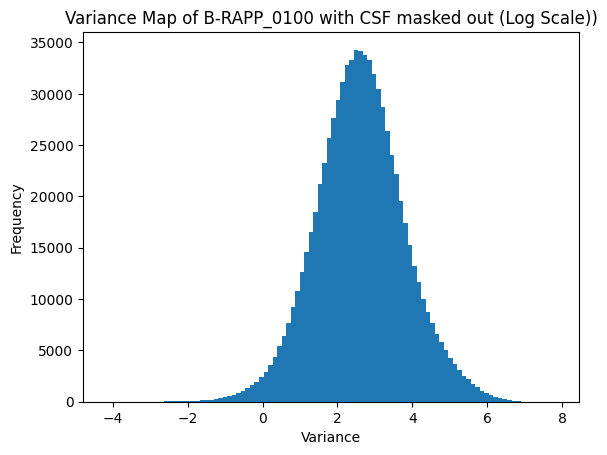

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# import the brain mask
brain_mask_file = nib.load('/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/brain_nifti/masks/B-RAP_0100_05_D1.nii')
brain_mask = brain_mask_file.get_fdata()

# mask the variance so we only look at the brain 
#convert binary mask to boolean
binary_mask = brain_mask.astype(bool)
variance_masked = variance_map_no_csf[binary_mask]

# flatten the variance
variance_map_no_csf_flat = variance_masked.flatten()

# only retain values greater than 0 as below are non-brain and csf voxels
variance_map_no_csf_flat = variance_map_no_csf_flat[variance_map_no_csf_flat > 0]

plt.hist(np.log(variance_map_no_csf_flat), bins=100)
plt.title('Variance Map of B-RAPP_0100 with CSF masked out (Log Scale))')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

In [6]:
# count how many zeroes or negative values
count = np.count_nonzero(variance_map_no_csf_flat < 0)
count

0

In [7]:
# Compute the Z-score on the above thresholded log variance map (i.e. no brain)
variance_map_no_csf_flat_log= np.log(variance_map_no_csf_flat) # this should only contain the brain and not the csf
mu = np.mean(variance_map_no_csf_flat_log) 
stdev = np.std(variance_map_no_csf_flat_log)

# preallocate Z-score map array
Z_score_map = np.zeros(variance_map.shape)

# go through all points in the two images to compute the Z-score
# iterate through each 'voxel' in the images
for i in range(Z_score_map.shape[0]):
        for j in range(Z_score_map.shape[1]):
                for k in range(Z_score_map.shape[2]):
                                # check if the voxel is in the brain
                                if binary_mask[i,j,k] == True and variance_map_no_csf[i,j,k] > 0:
                                        # compute the Z-score
                                                z_score = (np.log(variance_map_no_csf[i,j,k]) - mu)/stdev
                                                Z_score_map[i,j,k] = z_score
                        
                                if variance_map_no_csf[i,j,k] == 0:
                                        Z_score_map[i,j,k] = -1e6 # set the csf to a very low value so we can threshold it later


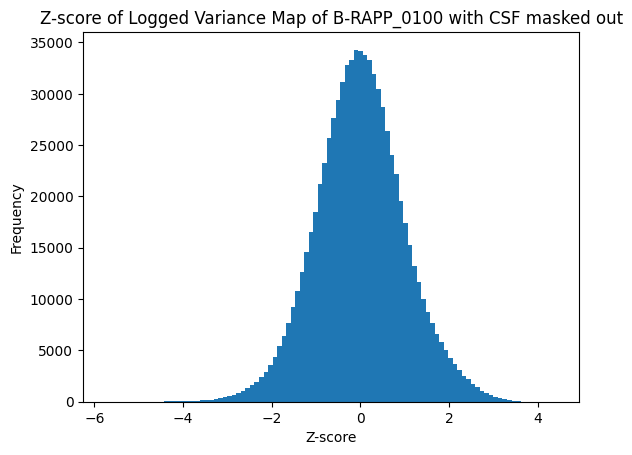

In [8]:
# look at the histogram of the z-score only considering the brain
variance_Z_brain = Z_score_map[binary_mask]
variance_Z_flat = variance_Z_brain.flatten()
#variance_map_no_csf_flat_thresh = variance_map_no_csf_flat[np.where(variance_map_no_csf_flat > thresh)]#np.logical_and(variance_map_no_csf_flat > 1.5, variance_map_no_csf_flat < 200)]
variance_Z_flat = variance_Z_flat[variance_Z_flat > -1e6]
plt.hist(variance_Z_flat, bins=100) # threshold out the csf
plt.title('Z-score of Logged Variance Map of B-RAPP_0100 with CSF masked out')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.show()

In [13]:
# find the 95th percentile of this distribution above the threshold:
threshold=np.percentile(variance_Z_flat[variance_Z_flat > -1e6], 95)  
threshold

1.6919582233811932

In [10]:
# run again with the z-score of the csf set to 0 because this will be removed by the clustering
# Compute the Z-score on the above thresholded log variance map (i.e. no brain)
variance_map_no_csf_flat_log= np.log(variance_map_no_csf_flat) # this should only contain the brain
mu = np.mean(variance_map_no_csf_flat_log) # only consider values above the threshold for the distribution
stdev = np.std(variance_map_no_csf_flat_log)

# preallocate Z-score map array
Z_score_map = np.zeros(variance_map.shape)

# go through all points in the two images to compute the Z-score
# iterate through each 'voxel' in the images
for i in range(Z_score_map.shape[0]):
        for j in range(Z_score_map.shape[1]):
                for k in range(Z_score_map.shape[2]):
                                # check if the voxel is in the brain
                                if binary_mask[i,j,k] == True and variance_map_no_csf[i,j,k] > 0:
                                        # compute the Z-score
                                                z_score = (np.log(variance_map_no_csf[i,j,k]) - mu)/stdev
                                                Z_score_map[i,j,k] = z_score
                        
# save the map
Z_score_map_thresh_nifti = nib.Nifti1Image(Z_score_map, affine=None)
out_file = "/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/z_score_map_no_csf.nii.gz"
# ensure that the images are in the same space as the original
Z_score_map_thresh_nifti.set_sform(brain_mask_file.get_sform())
Z_score_map_thresh_nifti.set_qform(brain_mask_file.get_qform())
nib.save(Z_score_map_thresh_nifti, out_file)

After running Z-score calculation on the CSF-free variance map and obtaining the cluster map, we need to analyse the clusters. This is for B-RAPP_0100 Affine Variance.

fsl-cluster -i /home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/affine_intrasubject_no_csf/variance_z_score_map_affine.nii.gz -t 1.5 -o /home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/clusters/intrasubject/variance_affine_no_csf.nii.gz -> /home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/clusters/intrasubject/variance_affine_no_csf_cluster_info.txt

In [19]:
Z_score_file = out_file
clustered_data_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/no_csf/raw_clusters.nii.gz'
cluster_txt_file= '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/no_csf/cluster_info.txt'

# 2) use FSL cluster
command = f"fsl-cluster -i {Z_score_file} -t {threshold} -o {clustered_data_file} -> {cluster_txt_file} "
os.system(command)

0

In [47]:
# load in the cluster information CSV
B_RAPP_0100_var_cluster_info = pd.read_csv('/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/no_csf/cluster_info.txt', delimiter='\t')
B_RAPP_0100_var_cluster_info.head()

,Cluster Index,Voxels,MAX,MAX X (vox),MAX Y (vox),MAX Z (vox),COG X (vox),COG Y (vox),COG Z (vox)
0,2320,10224,4.00,65,37,155,66.8,40.4,169
1,2319,3370,4.24,80,65,103,85.4,86.4,118
2,2318,1510,3.28,98,110,159,104.0,110.0,166
3,2317,1440,2.96,107,55,211,113.0,58.7,202
4,2316,1340,2.98,66,79,216,67.2,84.9,214


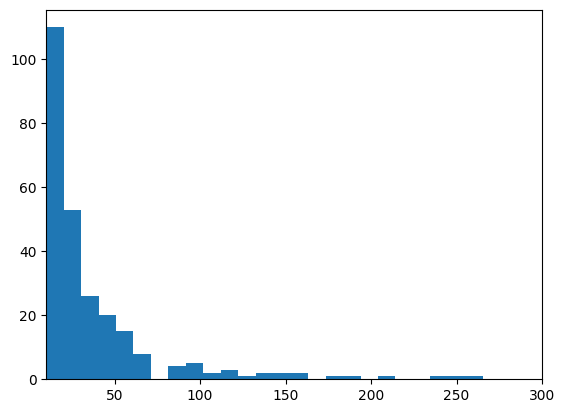

In [27]:
# display histogram of cluster sizes
plt.hist(B_RAPP_0100_var_cluster_info[B_RAPP_0100_var_cluster_info['Voxels'] >= 10]['Voxels'], bins=1000)
# limit the x axis to 3000
plt.xlim(10,300)
plt.show()

In [11]:
# count number of clusters with more than 10 voxels
num_clusters = len(B_RAPP_0100_var_cluster_info[B_RAPP_0100_var_cluster_info['Voxels'] >= 10])
num_clusters

64

In [41]:
# mean cluster size
print(np.mean(B_RAPP_0100_var_cluster_info[B_RAPP_0100_var_cluster_info['Voxels'] >= 10]['Voxels']))
print(np.median(B_RAPP_0100_var_cluster_info[B_RAPP_0100_var_cluster_info['Voxels'] >= 10]['Voxels']))

128.27636363636364
24.0


In [42]:
# extract the cluster indices for the clusters with more than or equal to 10 voxels
big_clusters = B_RAPP_0100_var_cluster_info[B_RAPP_0100_var_cluster_info['Voxels'] >= 10]
big_clusters

,Cluster Index,Voxels,MAX,MAX X (vox),MAX Y (vox),MAX Z (vox),COG X (vox),COG Y (vox),COG Z (vox)
0,2320,10224,4.00,65,37,155,66.8,40.4,169
1,2319,3370,4.24,80,65,103,85.4,86.4,118
2,2318,1510,3.28,98,110,159,104.0,110.0,166
3,2317,1440,2.96,107,55,211,113.0,58.7,202
4,2316,1340,2.98,66,79,216,67.2,84.9,214
...,...,...,...,...,...,...,...,...,...
270,2050,10,2.16,36,104,197,37.0,104.0,198
271,2049,10,2.12,53,145,179,51.2,147.0,180
272,2048,10,2.08,107,57,138,106.0,58.5,139
273,2047,10,2.02,66,43,140,65.6,44.0,140


In [43]:
# these cluster indices are equal to the intensity values of the cluster in the variance map. Therefore, we want to select the voxels in the variance map that have these intensity values. 
# this ensures we only retain the biggest clusters.
# load in the clustered z-score variance map without csf
B_RAPP_0100_var_cluster_map = nib.load('/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/no_csf/raw_clusters.nii.gz').get_fdata()
# verify the map intensity values to see if it matches the pd dataframe by extracting max value
np.max(B_RAPP_0100_var_cluster_map)

2320.0

In [44]:
np.min(big_clusters['Cluster Index'].tolist()) # this is the threshold of the cluster indices such that the higher indices > 10

2046

In [48]:
# threshold the cluster map
thresh = fsl.Threshold()
thresh.inputs.in_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/no_csf/raw_clusters.nii.gz'
thresh.inputs.thresh = np.min(big_clusters['Cluster Index'].tolist()) 
thresh.inputs.direction = 'below'
thresh.inputs.out_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/no_csf/thresholded_clusters.nii.gz'
thresh.run()
print('Thresholded cluster map')

Thresholded cluster map


In [50]:
# read in thresholded cluster map and extract unique values for verification
B_RAPP_0100_var_cluster_map_thresh = nib.load('/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/no_csf/thresholded_clusters.nii.gz').get_fdata()
print(np.unique(B_RAPP_0100_var_cluster_map_thresh))

[   0. 2046. 2047. 2048. 2049. 2050. 2051. 2052. 2053. 2054. 2055. 2056.
 2057. 2058. 2059. 2060. 2061. 2062. 2063. 2064. 2065. 2066. 2067. 2068.
 2069. 2070. 2071. 2072. 2073. 2074. 2075. 2076. 2077. 2078. 2079. 2080.
 2081. 2082. 2083. 2084. 2085. 2086. 2087. 2088. 2089. 2090. 2091. 2092.
 2093. 2094. 2095. 2096. 2097. 2098. 2099. 2100. 2101. 2102. 2103. 2104.
 2105. 2106. 2107. 2108. 2109. 2110. 2111. 2112. 2113. 2114. 2115. 2116.
 2117. 2118. 2119. 2120. 2121. 2122. 2123. 2124. 2125. 2126. 2127. 2128.
 2129. 2130. 2131. 2132. 2133. 2134. 2135. 2136. 2137. 2138. 2139. 2140.
 2141. 2142. 2143. 2144. 2145. 2146. 2147. 2148. 2149. 2150. 2151. 2152.
 2153. 2154. 2155. 2156. 2157. 2158. 2159. 2160. 2161. 2162. 2163. 2164.
 2165. 2166. 2167. 2168. 2169. 2170. 2171. 2172. 2173. 2174. 2175. 2176.
 2177. 2178. 2179. 2180. 2181. 2182. 2183. 2184. 2185. 2186. 2187. 2188.
 2189. 2190. 2191. 2192. 2193. 2194. 2195. 2196. 2197. 2198. 2199. 2200.
 2201. 2202. 2203. 2204. 2205. 2206. 2207. 2208. 22

It's hard to see these thresholds because they're so close, so allocate a mapping between cluster labels and cluster size.

In [54]:
# visualise by cluster size

unique_labels = np.unique(B_RAPP_0100_var_cluster_map_thresh)

voxel_size = big_clusters['Voxels'].tolist()
voxel_size.reverse()
voxel_size.insert(0, 0) # for background

# extract voxels from big clusters

value_to_intensity = {original:vox_size for original, vox_size in zip(unique_labels, voxel_size)}
print(value_to_intensity)

# Map cluster labels to intensity values using the dictionary
vox_mapped_image = np.vectorize(value_to_intensity.get, otypes=[int])(B_RAPP_0100_var_cluster_map_thresh)

# save the map
mapped_vox_size_var_no_csf_nifti =  nib.Nifti1Image(vox_mapped_image, affine=None)
out_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/no_csf/adjusted_intensity_thresholded_clusters.nii.gz'
# ensure that the images are in the same space as the original
mapped_vox_size_var_no_csf_nifti.set_sform(brain_mask_file.get_sform())
mapped_vox_size_var_no_csf_nifti.set_qform(brain_mask_file.get_qform())
nib.save(mapped_vox_size_var_no_csf_nifti, out_file)

{0.0: 0, 2046.0: 10, 2047.0: 10, 2048.0: 10, 2049.0: 10, 2050.0: 10, 2051.0: 10, 2052.0: 10, 2053.0: 10, 2054.0: 10, 2055.0: 10, 2056.0: 10, 2057.0: 10, 2058.0: 10, 2059.0: 10, 2060.0: 10, 2061.0: 10, 2062.0: 10, 2063.0: 10, 2064.0: 10, 2065.0: 10, 2066.0: 11, 2067.0: 11, 2068.0: 11, 2069.0: 11, 2070.0: 11, 2071.0: 11, 2072.0: 11, 2073.0: 11, 2074.0: 11, 2075.0: 11, 2076.0: 11, 2077.0: 11, 2078.0: 11, 2079.0: 11, 2080.0: 11, 2081.0: 11, 2082.0: 12, 2083.0: 12, 2084.0: 12, 2085.0: 12, 2086.0: 12, 2087.0: 12, 2088.0: 12, 2089.0: 13, 2090.0: 13, 2091.0: 13, 2092.0: 13, 2093.0: 13, 2094.0: 13, 2095.0: 13, 2096.0: 13, 2097.0: 13, 2098.0: 13, 2099.0: 13, 2100.0: 13, 2101.0: 13, 2102.0: 14, 2103.0: 14, 2104.0: 14, 2105.0: 14, 2106.0: 14, 2107.0: 14, 2108.0: 14, 2109.0: 15, 2110.0: 15, 2111.0: 15, 2112.0: 15, 2113.0: 15, 2114.0: 15, 2115.0: 15, 2116.0: 15, 2117.0: 15, 2118.0: 16, 2119.0: 16, 2120.0: 16, 2121.0: 16, 2122.0: 16, 2123.0: 16, 2124.0: 16, 2125.0: 16, 2126.0: 16, 2127.0: 16, 2128.0:

### Repeat the above but for CSF isolated

In [56]:
# look at csf ARIA maps
out_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/variance_maps/B-RAP_0100_var_csf_only.nii.gz'

variance_map_only_csf = np.multiply(variance_map,csf_mask) # element-wise multiplication
print(variance_map_only_csf.shape)

# save the map
var_only_csf_nifti =  nib.Nifti1Image(variance_map_only_csf, affine=None)
# ensure that the images are in the same space as the original
var_only_csf_nifti.set_sform(csf_mask_file.get_sform())
var_only_csf_nifti.set_qform(csf_mask_file.get_qform())
nib.save(var_only_csf_nifti, out_file)

(176, 232, 256)


Explore the variance of csf to find a suitable cluster threshold.

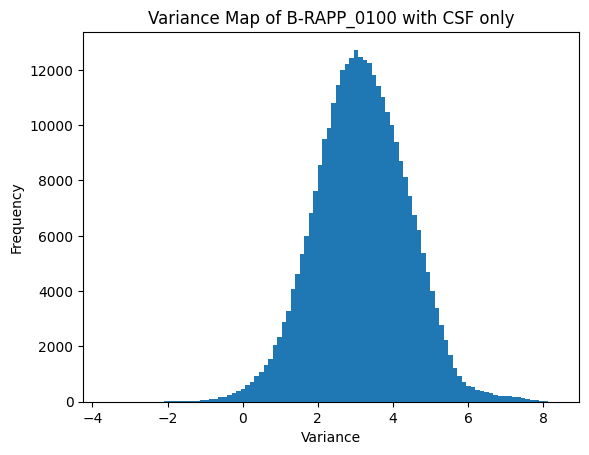

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline


variance_masked = variance_map_only_csf[binary_mask]

# we know that the non-csf values are now zero so we can remove them
variance_masked_csf_only = variance_masked[variance_masked > 0]

# flatten the variance
variance_map_only_csf_flat = variance_masked_csf_only.flatten()
plt.hist(np.log(variance_map_only_csf_flat), bins=100)
plt.title('Variance Map of B-RAPP_0100 with CSF only')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()


In [58]:
# Compute the Z-score on the above thresholded log variance map with csf only(i.e. no brain)
variance_map_only_csf_flat_log= np.log(variance_map_only_csf_flat) # this should only contain the brain
mu = np.mean(variance_map_only_csf_flat_log) # only consider values above the threshold for the distribution
stdev = np.std(variance_map_only_csf_flat_log)

# preallocate Z-score map array
Z_score_map = np.zeros(variance_map.shape)

# go through all points in the two images to compute the Z-score
# iterate through each 'voxel' in the images
for i in range(Z_score_map.shape[0]):
        for j in range(Z_score_map.shape[1]):
                for k in range(Z_score_map.shape[2]):
                                # check if the voxel is in the brain and above 0
                                if binary_mask[i,j,k] == True and variance_map_only_csf[i,j,k] > 0:
                                        # compute the Z-score
                                                z_score = (np.log(variance_map_only_csf[i,j,k]) - mu)/stdev
                                                Z_score_map[i,j,k] = z_score
                                if variance_map_only_csf[i,j,k] == 0:
                                        Z_score_map[i,j,k] = -1e6 # set the non-csf to a very low value so we can threshold it later
                        

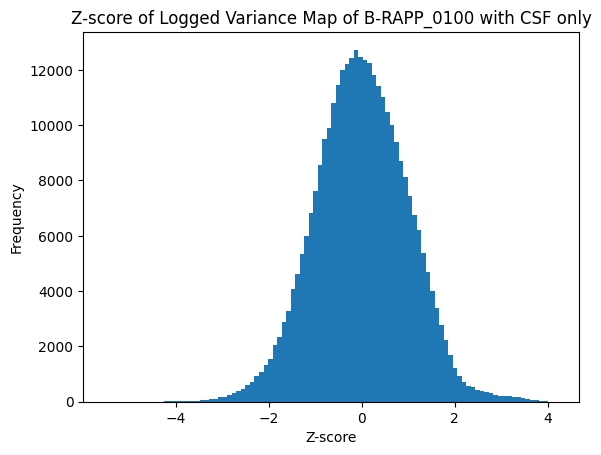

In [59]:
# look at the histogram of the z-score only considering the brain and CSF
variance_Z_brain = Z_score_map[binary_mask]
variance_Z_flat = variance_Z_brain.flatten()
# threshold out the non-csf values
variance_Z_flat = variance_Z_flat[variance_Z_flat > -1e6]
plt.hist(variance_Z_flat, bins=100)
plt.title('Z-score of Logged Variance Map of B-RAPP_0100 with CSF only')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.show()

In [61]:
# find the 95th percentile of this distribution above the threshold:
threshold = np.percentile(variance_Z_flat[variance_Z_flat > -1e6], 95)  # nice normal so we can use typical values
threshold

1.6006925812455535

In [62]:
# Now to do the clustering, we need the Z-score map to have those original zeros back
# Compute the Z-score on the above thresholded log variance map with csf only(i.e. no brain)
variance_map_only_csf_flat_log= np.log(variance_map_only_csf_flat) # this should only contain the brain
mu = np.mean(variance_map_only_csf_flat_log) # only consider values above the threshold for the distribution
stdev = np.std(variance_map_only_csf_flat_log)

# preallocate Z-score map array
Z_score_map_zeros = np.zeros(variance_map.shape)

# go through all points in the two images to compute the Z-score
# iterate through each 'voxel' in the images
for i in range(Z_score_map_zeros.shape[0]):
        for j in range(Z_score_map_zeros.shape[1]):
                for k in range(Z_score_map_zeros.shape[2]):
                                # check if the voxel is in the brain and above 0
                                if binary_mask[i,j,k] == True and variance_map_only_csf[i,j,k] > 0:
                                        # compute the Z-score
                                                z_score = (np.log(variance_map_only_csf[i,j,k]) - mu)/stdev
                                                Z_score_map_zeros[i,j,k] = z_score
# save the map
Z_score_map_zeros_nifti = nib.Nifti1Image(Z_score_map_zeros, affine=None)
# ensure that the images are in the same space as the original
Z_score_map_zeros_nifti.set_sform(csf_mask_file.get_sform())
Z_score_map_zeros_nifti.set_qform(csf_mask_file.get_qform())
out_file = "/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/z_score_map_csf_only.nii.gz"
nib.save(Z_score_map_zeros_nifti, out_file)                 
                        

Run the clustering. TODO: code this section.

fsl-cluster -i /home/ela/Documents/ -t 1.895 -o /home/ela/Documents/ -> /home/ela/Documents/


In [63]:
Z_score_file = out_file
clustered_data_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/csf_only/raw_clusters.nii.gz'
cluster_txt_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/csf_only/cluster_info.txt'

# 2) use FSL cluster
command = f"fsl-cluster -i {Z_score_file} -t {threshold} -o {clustered_data_file} -> {cluster_txt_file} "
os.system(command)

0

In [64]:
# load in the cluster information CSV
B_RAPP_0100_var_cluster_info = pd.read_csv(cluster_txt_file, delimiter='\t')
B_RAPP_0100_var_cluster_info.head()

,Cluster Index,Voxels,MAX,MAX X (vox),MAX Y (vox),MAX Z (vox),COG X (vox),COG Y (vox),COG Z (vox)
0,1210,4630,4.19,89,66,101,84.6,81.5,114
1,1209,1843,3.57,59,39,178,66.6,34.9,178
2,1208,1469,3.69,66,39,158,63.6,56.3,164
3,1207,442,2.71,53,52,183,58.3,54.9,190
4,1206,281,2.81,47,52,166,47.8,45.0,175


In [66]:
# count number of clusters with more than 10 voxels
num_clusters = len(B_RAPP_0100_var_cluster_info[B_RAPP_0100_var_cluster_info['Voxels'] >= 10])

# extract the cluster indices for the clusters with more than or equal to 10 voxels
big_clusters = B_RAPP_0100_var_cluster_info[B_RAPP_0100_var_cluster_info['Voxels'] >= 10]

# these cluster indices are equal to the intensity values of the cluster in the variance map. Therefore, we want to select the voxels in the variance map that have these intensity values. 
# this ensures we only retain the biggest clusters.
# load in the clustered z-score variance map with csf
B_RAPP_0100_var_cluster_map = nib.load('/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/csf_only/raw_clusters.nii.gz').get_fdata()
# verify the map intensity values to see if it matches the pd dataframe by extracting max value
np.max(B_RAPP_0100_var_cluster_map)

# threshold the cluster map
thresh = fsl.Threshold()
thresh.inputs.in_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/csf_only/raw_clusters.nii.gz'
thresh.inputs.thresh = np.min(big_clusters['Cluster Index'].tolist()) 
thresh.inputs.direction = 'below'
thresh.inputs.out_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/csf_only/thresholded_clusters.nii.gz'
thresh.run()
print('Thresholded cluster map')

# visualise by cluster size

# read in thresholded cluster map and extract unique values for verification
B_RAPP_0100_var_cluster_map_thresh = nib.load('/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/csf_only/thresholded_clusters.nii.gz').get_fdata()

unique_labels = np.unique(B_RAPP_0100_var_cluster_map_thresh)

voxel_size = big_clusters['Voxels'].tolist()
voxel_size.reverse()
voxel_size.insert(0, 0) # for background

# extract voxels from big clusters

value_to_intensity = {original:vox_size for original, vox_size in zip(unique_labels, voxel_size)}
print(value_to_intensity)

# Map cluster labels to intensity values using the dictionary
vox_mapped_image = np.vectorize(value_to_intensity.get, otypes=[int])(B_RAPP_0100_var_cluster_map_thresh)

# save the map
mapped_vox_size_var_no_csf_nifti =  nib.Nifti1Image(vox_mapped_image, affine=None)
# ensure that the images are in the same space as the original
mapped_vox_size_var_no_csf_nifti.set_sform(csf_mask_file.get_sform())
mapped_vox_size_var_no_csf_nifti.set_qform(csf_mask_file.get_qform())
out_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/variance/clusters/csf_only/adjusted_intensity_thresholded_clusters.nii.gz'
nib.save(mapped_vox_size_var_no_csf_nifti, out_file)

Thresholded cluster map
{0.0: 0, 1060.0: 10, 1061.0: 10, 1062.0: 10, 1063.0: 10, 1064.0: 10, 1065.0: 10, 1066.0: 10, 1067.0: 10, 1068.0: 10, 1069.0: 11, 1070.0: 11, 1071.0: 11, 1072.0: 11, 1073.0: 11, 1074.0: 11, 1075.0: 11, 1076.0: 11, 1077.0: 11, 1078.0: 11, 1079.0: 11, 1080.0: 12, 1081.0: 12, 1082.0: 12, 1083.0: 12, 1084.0: 12, 1085.0: 12, 1086.0: 12, 1087.0: 12, 1088.0: 12, 1089.0: 12, 1090.0: 12, 1091.0: 12, 1092.0: 12, 1093.0: 12, 1094.0: 12, 1095.0: 13, 1096.0: 13, 1097.0: 13, 1098.0: 13, 1099.0: 13, 1100.0: 13, 1101.0: 13, 1102.0: 13, 1103.0: 13, 1104.0: 13, 1105.0: 14, 1106.0: 14, 1107.0: 14, 1108.0: 14, 1109.0: 14, 1110.0: 14, 1111.0: 15, 1112.0: 15, 1113.0: 15, 1114.0: 15, 1115.0: 15, 1116.0: 15, 1117.0: 15, 1118.0: 16, 1119.0: 16, 1120.0: 16, 1121.0: 16, 1122.0: 17, 1123.0: 17, 1124.0: 17, 1125.0: 17, 1126.0: 18, 1127.0: 18, 1128.0: 18, 1129.0: 18, 1130.0: 18, 1131.0: 18, 1132.0: 19, 1133.0: 19, 1134.0: 19, 1135.0: 19, 1136.0: 20, 1137.0: 20, 1138.0: 20, 1139.0: 20, 1140.0:

Investigate problem with nib and original image space

In [36]:
# load in normalised image and original image
normalised_img = nib.load('/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/normalised_nifti/affine/B-RAP_0100_03_D1.nii.gz')
normalised_img_data = normalised_img.get_fdata()
original_brain = nib.load('/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/bias_nifti/affine/B-RAP_0100_03_D1_restore.nii.gz')

In [37]:
original_shape= original_brain.shape
normalised_shape = normalised_img.shape
if original_shape != normalised_shape:
    print("Original and normalized images have different dimensions.")

original_qform = original_brain.header.get_qform()
normalized_qform = normalised_img.header.get_qform()

if not np.array_equal(original_qform, normalized_qform):
    print("Coordinate systems are not the same.")

Coordinate systems are not the same.


In [34]:
print(normalised_img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 176 232 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'2203.8-dirty 2023-04-27T16:47:05+01:00'
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x     

In [30]:
print(original_brain.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 176 232 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.      1.1     1.09375 1.09375 0.      0.      0.      0.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'2203.8-dirty 2023-04-27T16:47:05+01:00'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.06185927
quatern_c       : 0.0049368297
quatern_d       : -0.020989755
qoffset_x   

# Perform Cluster Based Statistics
Here, I am implementing permutation based statistics. This is spatial permutation, not time.

## Step 1: generate the null distribution using permutation

In [ ]:
z_scores_data = Z_score_map

# select cluster threshold
threshokd = 1.96 # 95th percentile

# set the number of cluster permutations
n_perm = 1000

# initialise array to store cluster sizes
cluster_sizes = []

# set random seed for repeatability
np.random.seed(42)

# permutation procedure

for i in range(n_perm):
    # create new null dataset by shuffling the random values in the 3D-map
    null_data = np.copy(Z_score_map) * binary_mask  # create a copy of the data for safety and then mask it according to the brain mask
    null_data = np.random.permutation(null_data)  # shuffle the dataa
    
    # apply clustering to the data using FSL-cluster
    #1) save the permuted null_data to file 
    null_data_nifti = nib.Nifti1Image(null_data, affine=np.eye(4))
    null_data_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/clusters/intrasubject/permutations/null_data_permuted.nii.gz'
    cluster_txt_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/clusters/intrasubject/permutations/null_data_permuted_cluster_info.txt'
    clustered_null_data_file = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/clusters/intrasubject/permutations/null_data_permuted_clustered.nii.gz'
    nib.save(null_data_nifti, null_data_file)
    
    # 2) use FSL cluster
    command = f"fsl-cluster -i {null_data_file} -t 1.96 -o {clustered_null_data_file} -> {cluster_txt_file} "
    os.system(command)

    # 3) load in the cluster info to find cluster sizes
    null_cluster_info = pd.read_csv(cluster_txt_file, delimiter='\t')
    # 4) find the cluster sizes and extract the values larger than the threshold of 10 for comparison
    null_cluster_sizes = null_cluster_info["Voxels"].to_numpy() 
    null_cluster_sizes = null_cluster_sizes[null_cluster_sizes >= 10]
    # 5) append the cluster sizes to the array
    cluster_sizes.append(null_cluster_sizes)

    print(f"Permutation {i+1} complete")

# save the cluster sizes to a csv file
np.savetxt('/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/z_score_maps/clusters/intrasubject/permutations/null_cluster_sizes.csv', cluster_sizes, delimiter=',')




Look at CSF only now!